In [ ]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

# Support Vector Machines

Support vector machines are a popular class of machine learning models that were developed in the 1990s. They are capable of both linear and non-linear classification and can also be used for regression and anomaly/outlier detection. They work well for wide class of problems but are generally used for problems with small or medium sized data sets. In this notebook, we will start off with a simple classifier model and extend and improve it to ultimately arrive at what is referred to a support vector machine (SVM).

## Hard margin classifier

A hard margin classifier is a model that uses a hyperplane to completely separate two classes. A hyperplane is a subspace with one less dimension as the ambient space. For example, the hyperplane of a two dimensional space is a line and the hyperplane of a three dimensional space is a plane. It is helpful to consider each observation in our data set as existing in a $p$-dimensional space where $p$ is the number of features (columns) in our data. A hyperplane is simply a generalization of a plane in $p$-dimensional spaces. Take a look at the figure below, where we plot three such hyperplanes to separate two classes.

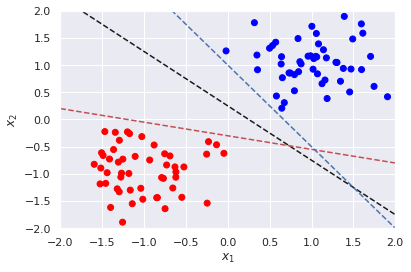

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=[[1, 1], [-1, -1]], cluster_std=0.4, random_state=0)
x = np.linspace(-2, 2, 100)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
plt.plot(x, -x+0.25, '--k')
plt.plot(x, -0.25*x-0.3, 'r--')
plt.plot(x, -1.5*x+1, 'b--')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$'); 

**Question**
* Of the three hyperplanes, which one should you choose to separate the two classes? What motivated your decision?

We not only want a classifier that will completely separate both classes but one that is situated an equal distance from the two classes. Such a classifier will likely be a better decision boundary for new data. Our model should not only seek for complete separation of our classes but also create the largest _margin_ between the two classes. To find the classifier that results in the largest margin, we need to first define the equation of a hyperplane and understand how to calculate distances. The equation for a $p$-dimensional hyperplane is

$$ x \cdot \tilde{\beta} + \tilde{\beta}_0 = 0. $$

$\tilde{\beta}$ defines the hyperplane and the set of $x$ that satisfies the above equation lie on the plane. Note, both $x$ and $\tilde{\beta}$ are $p$-dimensional vectors. For our classifier, we require that all points or *vectors* are on the correct side of the dividing hyperplane. If we enforce the $||\tilde{\beta}|| = 1$, then the result of $||x \cdot \tilde{\beta} + \tilde{\beta}_0||$ will be equal to the distance between the vector and the hyperplane. For our two classes, let's assign a value of $\pm 1$, where $y_j = +1$ and $y_j = -1$ are observations above and below the hyperplane, respectively. Under this convention, we seek to find a hyperplane that will satisfy the following criterion for all observations

$$ y_j(x_j \cdot \tilde{\beta} + \tilde{\beta}_0) \geq 0.$$ 

The value of the term inside the parenthesis will be positive for vectors located above the hyperplane and negative for vectors located below. Given our convention for the label values of $y_j \pm 1$, the inequality will be satisfied so long as the hyperplane perfectly separates the two classes. 

### Determining the maximum margin

For a given problem, there could be various hyperplanes that satisfy the above inequality; the three classifiers shown above all satisfy the inequality. We want a classifier the creates the largest possible margin; we will need to include the following constraint,

$$ y_j(x_j \cdot \tilde{\beta} + \tilde{\beta}_0) \geq M,$$

where $M$ is the size of the margin. Remember, the term $x_j \cdot \tilde{\beta} + \tilde{\beta}_0$ is the distance between a vector and the hyperplane and we require all vectors are at least $M$ distance away. For simplicity, we will define $\beta \equiv \tilde{\beta}/M$ and $\beta_0 \equiv \tilde{\beta}_0/M$ which results in $\| \beta \|_2 = 1/M$. To maximize, the margin, we need to minimize $\| \beta \|_2$.  The hyperplane resulting in the largest margin can be solved by 

$$ \min_{\beta, \beta_0} \frac{1}{2} \|\beta \|_2, $$

with the constraint

$$ y_j(x_j \cdot \beta + \beta_0) \geq 1.$$

Let's train the hard margin classifier on the data previously displayed.

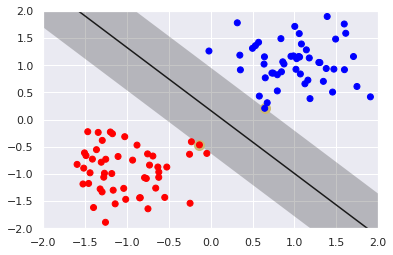

In [5]:
from ipywidgets import interact, IntSlider, FloatSlider, fixed

def plot_svc_interact(X, y):
    def plotter(log_C=1):
        clf = svm.SVC(C=10**log_C, kernel='linear')
        clf.fit(X, y)
    
        beta = clf.coef_[0]
        beta_0 = clf.intercept_
        slope = -beta[0]/beta[1]
        intercept = -beta_0/beta[1]
       
        x_max = np.ceil(np.abs(X).max())
        x = np.linspace(-x_max, x_max, 100)
        margin_bound_1 = 1/beta[1] + slope*x + intercept
        margin_bound_2 = -1/beta[1] + slope*x + intercept

        plt.plot(x, slope*x + intercept, 'k')
        plt.fill_between(x, margin_bound_1, margin_bound_2, color='k', alpha=0.25, linewidth=0)
        plt.scatter(*clf.support_vectors_.T, s=100, c='y')
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
        plt.axis([-x_max, x_max, -x_max, x_max])

    return plotter

plot_svc_interact(X, y)(log_C=2)

The figure displays the largest margin possible without having vectors inside the margin. The figure highlights two vectors, the vectors that prevent the margin from expanding. These vectors are referred to as _support vectors_ because they support the margin structure. You can think of the margin boundaries as a wall or fence and the support vectors help maintain or support the structure. The support vectors are the only vectors in the training set that influences the choice of hyperplane. Changing the values of the other vectors will not affect the margin, so long as they still stay out of the margin. 

**Questions**
* The choice of margin was only dictated by a few number of training data. Would you expect that this classifier to be prone to bias or variance error?
1. **yes, because gonna rely on only few points of the training data**
* What preprocessing should we apply to our data to make the algorithm work best?
1. **scale**

## Soft margin classifier

Not all cases is it possible to completely linearly separable the two classes. We need to relax the constraint that there be no margin violations. The result is what is called the soft-margin classifier. As before, we still look to create the largest possible margin but the model will incur a penalty for vectors that reside in the margin or are on the wrong side of the hyperplane. Mathematically, we are going to construct a margin such that

$$ \min_{\beta, \beta_0} \frac{1}{2}\| \beta \|_2 + C \sum_j \zeta_j, $$

with the constraints

$$ y_j(x_j \cdot \beta + \beta_0) \geq (1 - \zeta_j), $$

$$ \zeta_j \geq 0.$$

The severity of all the violations are controlled by the hyperparameter $C$ and the magnitude of the penalty for each vector is proportional to $\zeta_j$. The objective function we want to minimize has two parts, one that seeks for the largest margin and another the aims to reduce penalties from margin violations. Our constrain is slightly different from the hard margin classifier as it needs to consider that vectors may reside inside the margin. 

Each vector will have its own value of $\zeta$. If a vector does not reside inside the margin and is on the right side of the hyperplane, then $\zeta=0$ and we have the constraint for our hard margin classifier. These vectors will contribute to the cost function we want to minimize. If a vector is inside the margin, then $\zeta$ needs to be greater than 0 to still satisfy the constraint. If a vector lies on the hyperplane, then $x_j \cdot \beta + \beta_0 = 0$ and $\zeta $ must be at least equal to 1 to satisfy the constraint. If the vector is on the wrong side of the hyperplane, then $\zeta$ for that vector needs to be greater than 1.

Determining the hyperplane coefficients of the soft margin classifier involves solving a convex quadratic minimization with linear constraints. It can solved using quadratic programming solvers and the time complexity will be $O(np)$. The soft-margin classifier in `scikit-learn` is available using the `svm.LinearSVC` class.

**Questions**
* What other model had a cost function composed of two "competing" terms? Can you relate these terms to bias vs. variance?
* $C$ is a hyperparameter we must tune. How does changing $C$ affect variance and the number of support vectors?

The soft margin classifier uses the hinge loss function, named because it resembles a hinge. There is no loss so long as a threshold is not exceeded. Beyond the threshold, the loss ramps up linearly. See the figure below for an illustrations of a hinge loss function. Negative distance means the observation is on the wrong side of the hyperplane.

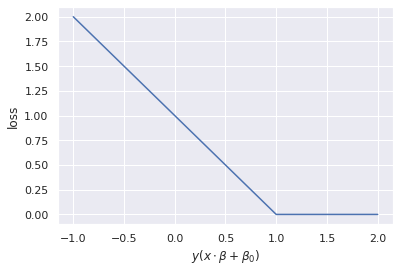

In [6]:
x = np.linspace(-1, 2, 100)
hinge_loss = lambda x: -(x-1) if x-1 < 0 else 0

plt.plot(x, list(map(hinge_loss, x)))
plt.xlabel("$y(x\cdot\\beta + \\beta_0$)")
plt.ylabel('loss');

We will train the soft margin classifier on a data set that is not completely linear separable. The interactive visualization allows you to modify the hyperparameter $C$. Consider the effect of increasing and decreasing $C$. Note, for tuning purposes, it's best to use a logarithmic scale.

In [6]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=[[1, 1], [-1, -1]], cluster_std=1.5, random_state=0, n_samples=200)

log_C_slider = FloatSlider(min=-4, max=2, step=0.25, value=0, description='$\log(C)$')
interact(plot_svc_interact(X, y), log_C=log_C_slider);

interactive(children=(FloatSlider(value=0.0, description='$\\log(C)$', max=2.0, min=-4.0, step=0.25), Output()…

## Kernels for non-linear classification

Using a hyperplane to separate the two classes will have limited performance as most problems require a non-linear decision boundary. One approach to overcome this limitation is to engineer non-linear features using the original features. Essentially, we are projecting our data onto a higher dimensional space where a linear classifier will perform substantially better. Consider the example below.

In [ ]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=200, noise=0.2, factor=0.25, random_state=0)
plt.scatter(*X.T, c=y, cmap=plt.cm.bwr)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

We clearly cannot linearly separate the two classes. However, we can create a new feature $x_3 = \sqrt{x_1^2 + x_2^2}$, the distance from the origin. With the new feature, we are projecting our data onto a higher dimensional space.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_projection(X, y):
    XX, YY = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
    ZZ = 0.6*np.ones((20, 20))
    x_3 = (X[:, 0]**2 + X[:, 1]**2)**0.5
    X_new = np.hstack((X, x_3.reshape(-1, 1)))

    def plotter(elev=30, azim=30):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter(*X_new.T, c=y, cmap=plt.cm.bwr)
        ax.plot_surface(XX, YY, ZZ, alpha=0.2);
        ax.view_init(elev, azim)
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_zlabel('$x_3$')

    return plotter

interact(plot_projection(X, y), elev=(0, 360), azim=(0, 360));

In this higher dimension, it is possible for a hyperplane to adequately divide the two classes. The resulting decision boundary on the original, lower dimensional space, is non-linear. Check out this [visualization](https://www.youtube.com/watch?v=3liCbRZPrZA) for another example of using projections to help the performance of the classifier.

In the example, we introduced the new non-linear term directly into data set. However, the way the objective function is solved allows us to _indirectly_ applying the projection, using what is called the kernel trick. A kernel is a function that creates the implicit mapping/projection to a higher dimensional space. The advantage of using a kernel trick are:

* No direct feature generation that increases the size of the data set.
* We can readily swap out and try different kernels to see which one performs the best.

With the kernel, we can now refer to our model as a support vector machine. More about the mathematically details about the kernel trick are explained at the end of the notebook.

### Choices of kernels

There are several popular choices of kernels; they are the polynomial, sigmoid, and Gaussian radial basis function (RBF). In `scikit-learn`, the choice of kernel is controlled by the keyword argument `kernel`. The table below 

<table>
<tr>
<th>Kernel Name</th>
<th>$K(x,x')$</th>
<th>`kernel` keyword argument</th>
</tr>

<tr>
<td>Linear Kernel</td>
<td>$x \cdot x'$</td>
<td>`'linear'`</td>
</tr>

<tr>
<td>$d$-th Degree Polynomial</td>
<td>&nbsp; &nbsp; &nbsp;$(r + \gamma\ x \cdot x')^d$    </td>
<td>`poly'`</td>
</tr>

<tr>
<td>Gaussian RBF</td>
<td>&nbsp; $\exp{(- \gamma\, \|x - x' \|_2)} $</td>
<td>`'rbf'`</td>
</tr>

<tr>
<td>Sigmoid</td>
<td>&nbsp; &nbsp; &nbsp; $\tanh(\gamma\, x \cdot x' + r)$</td>
<td>`'sigmoid'`</td>
</tr>
</table>

Usually, the radial basis function kernel will perform the best and there's only one additional hyperparameter to tune, $\gamma$. An interesting note is that using the radial basis function kernel is equivalent to projecting our vectors to an infinite dimensional space. It would not be possible to use the radial basis function kernel without the kernel trick.

The following blocks of code create an interactive visualization where you can experiment with different kernels and hyperparameter values for a situation where a non-linear decision boundary is required.

In [ ]:
def plot_decision_boundary(X_train, X_test, y_train, y_test):
    def plotter(kernel='linear', log_gamma=1, log_C=1, deg=1, coef0=1):
        clf = svm.SVC(C=10**log_C, kernel=kernel, gamma=10**log_gamma, coef0=coef0, probability=True)
        clf.fit(X_train, y_train)
        
        X1, X2 = np.meshgrid(np.linspace(-2, 3), np.linspace(-2, 2))
        y_proba = clf.predict_proba(np.hstack((X1.reshape(-1, 1), X2.reshape(-1, 1))))[:, 1]
        plt.contourf(X1, X2, y_proba.reshape(50, 50), 16, cmap=plt.cm.bwr, alpha=0.75)
        plt.colorbar()

        accuracy = clf.score(X_test, y_test)
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='white', cmap=plt.cm.bwr)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.title('test set accuracy: {}'.format(accuracy));

    return plotter

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(400, noise=0.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

log_C_slider = FloatSlider(min=-4, max=4, step=0.25, value=0, description='$\log(C)$')
log_gamma_slider = FloatSlider(min=-3, max=2, step=0.01, value=0, description='$\log(\gamma$)')
deg_slider = IntSlider(min=1, max=4, step=1, value=2, description='$d$')
coef0_slider = FloatSlider(min=-100, max=100, step=0.1, value=0, description='$r$')

interact(plot_decision_boundary(X_train, X_test, y_train, y_test),
         log_C=log_C_slider,
         log_gamma=log_gamma_slider, 
         kernel=['rbf', 'linear', 'sigmoid', 'poly'],
         deg=deg_slider,
         coef0=coef0_slider);

## Comparison with logistic regression

The SVM models resembles that of logistic regression. They are both linear binary classifiers, if we ignore the kernelized version. The difference between the two methods is the cost function they use to determine model parameters. The logistic regression uses the log loss while SVM uses the hinge loss. Both functions are plotted below.

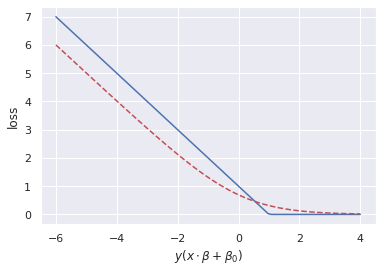

In [7]:
x = np.linspace(-6, 4, 100)
hinge_loss = lambda x: -(x-1) if x < 1 else 0
log_loss = np.log(1+np.exp(-x))

plt.plot(x, list(map(hinge_loss, x)))
plt.plot(x, log_loss, '--r')
plt.xlabel("$y(x \cdot \\beta + \\beta_0)$")
plt.ylabel('loss');

The two cost functions have the same limiting behavior. 

* If an observation is on the correct side of the hyperplane and very far away, large **positive** value of $y(x\cdot\beta + \beta_0)$, it will have _nearly_ zero loss for the log loss and exactly zero for the hinge loss.

* If an observation is on the wrong side of the hyperplane and very far away, large **negative** value of $y(x\cdot\beta + \beta_0)$, the log loss penalty is linear with respect to the distance to the hyperplane.  The hinge loss penalty is always linear.

The matching limiting behavior, as $z \to \pm \infty$, can be observed in the equations for the loss functions,

$$ C_\text{log} = \ln(1 + \exp(-z), $$

$$ C_\text{hinge} = \max(0, 1 - z) $$
where
$$ z = y(x\cdot \beta + \beta_0).$$

The difference occurs in the intermediate zone. SVM uses a threshold; if the observation is not inside the margin and on the right side of the hyperplane, there is no penalty. It does not matter how far away from the hyperplane the observation is located, so long as it still on correct side and not in the margin. This allows for the model to generalize better. For logistic regression, there will always be non-zero loss. Since every observation will have a cost, the model will need to "satisfy" each observation with regards to where to locate the hyperplane. Logistic regression will hurt the models ability to generalize. Note, a regularization term is often added to the logistic regression cost function, helping it generalize. Despite these differences, logistic regression and linear SVM often achieve similar results.

Here are some things to consider when choosing which of the two models to use.

* If calculating probabilities is important, use **logistic regression** as it is a probabilistic model.
* If the data is sufficiently linearly separable, both models can be used but **SVM** may work better in the presence of outliers.
* If the two classes are not linearly separable, use **SVM** with a kernel.
* If there is a large number of observations, 50,000 - 100,000, and a small number of features, it is best to manually create new features and use **logistic regression** or **linear SVM**. Kernelized SVM is slow to train with large number of observations.

The following visualization lets you use either a linear regression or SVM. You can control the separation of the clusters as well as the presence of an outlier. Notice how the SVM works better than linear regression when there is an outlier.

In [9]:
from sklearn.linear_model import LogisticRegression

def plot_svc_vs_lr(cluster_std=0.8, log_C=1, model='logistic regression', outlier=False):
    X, y = make_blobs(centers=[[1, 1], [-1, -1]], cluster_std=cluster_std, random_state=0)

    if outlier:
        X = np.vstack((X, [-1.5, 0.]))
        y = np.hstack((y, [0]))

    name_to_clf = {'logistic regression': LogisticRegression(C=10**log_C, solver='lbfgs'),
              'SVM': svm.SVC(C=10**log_C, kernel='linear')}
    
    clf = name_to_clf[model]
    clf.fit(X, y)
    
    beta = clf.coef_[0]
    beta_0 = clf.intercept_
    slope = -beta[0]/beta[1]
    intercept = -beta_0/beta[1]
       
    x_max = np.ceil(np.abs(X).max())
    x = np.linspace(-x_max, x_max, 100)

    plt.plot(x, slope*x + intercept, 'k')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr)
    plt.axis([-x_max, x_max, -x_max, x_max])

In [10]:
log_C_slider = FloatSlider(min=-4, max=4, step=0.25, value=1, description='$\log(C)$')
cluster_std_slider = FloatSlider(min=0.2, max=1.0, step=0.05, value=0.8, description='cluster $\sigma$')

interact(plot_svc_vs_lr,
         cluster_std=cluster_std_slider,
         log_C=log_C_slider,
         model=['logistic regression', 'SVM']);

interactive(children=(FloatSlider(value=0.8, description='cluster $\\sigma$', max=1.0, min=0.2, step=0.05), Fl…

## SVM for regression

SVMs can be also be used for regression with some modifications to the constrained optimization. Instead of constructing a margin that avoids penalties incurred by vectors residing inside the margin, we train a model that includes as many vectors *inside* the margin as possible. Now, vectors that are inside the margin carry no penalty but will incur one if they are outside of the margin. Similarly as before, the penalty ramps up linearly the farther away the vector is from the edge of the margin. Instead of a hinge loss, the SVM regressor uses a well-loss cost function, shown below.

In [ ]:
eps = 0.25
x = np.linspace(-1, 1, 100)
well_loss = list(map(lambda x: abs(x)-eps if abs(x) > eps else 0, x))
square_loss = x**2

plt.plot(x, well_loss)
plt.plot(x, square_loss)
plt.xlabel('distance from the center')
plt.ylabel('loss')
plt.legend(['well loss', 'square loss']);

The new optimization is
$$ \min_{\beta, \beta_0, \zeta_j, \zeta^*_j} \frac{1}{2} \|\beta \|_2 + C \sum_j (\zeta_j + \zeta^*_j) $$
with the following constraints
$$ y_j - \beta \cdot x_j - \beta_0 \leq \epsilon + \zeta_i, $$
$$ \beta \cdot x_j + \beta_0 - y_j \leq \epsilon + \zeta^*_i, $$
$$ \zeta_i, \zeta^* \geq 0. $$

The optimization problem is very similar as before but now we have two $\zeta$ values for each vector since our model will incur a penalty if a vector resides on either side of the margin. The hyperparameter $\epsilon$ determines the thickness of the margin and $C$ acts as the same way as with SVM classifier. In `scikit-learn` the linear SVM regressor is accessed from `svm.LinearSVR` while the kernelized SVM is accessed via `svm.SVR`.

The following interactive visualization allows you to see the effect of alternating $C$ and $\epsilon$ on a data set with a linear behavior.

In [11]:
def plot_svr_interact(X, y):
    def plotter(epsilon=0.5, log_C=2):
        rgr = svm.SVR(kernel='linear', epsilon=epsilon, C=10**log_C)
        rgr.fit(X, y)
    
        y_pred = rgr.predict(X)
        ind = np.abs(y - y_pred) >= epsilon

        plt.scatter(X[ind], y[ind], s=100, color='y')
        plt.scatter(X, y)
        plt.fill_between(X.reshape(-1,), y_pred - epsilon,  y_pred + epsilon, alpha=0.25, color='k', linewidth=0)
        plt.plot(X, y_pred, '-k')
        plt.xlabel('$x$')
        plt.ylabel('$y$')

    return plotter

In [12]:
np.random.seed(0)
x = np.linspace(-1, 1, 100)
y = 2*x + 1 + 0.5*np.random.randn(100)

log_C_slider = FloatSlider(min=-3, max=1, step=0.05, value=-1, description='$\log(C)$')
epsilon_slider = FloatSlider(min=0.05, max=2, step=0.05, value=0.5, description='$\epsilon$')
interact(plot_svr_interact(x.reshape(-1, 1), y), log_C=log_C_slider, epsilon=epsilon_slider);

interactive(children=(FloatSlider(value=0.5, description='$\\epsilon$', max=2.0, min=0.05, step=0.05), FloatSl…

## Exercises

1. Use `SVR` for the California housing data; you should experiment with using different kernels. What kernel works the best?
1. Support vector regression (with a linear kernel) and linear regression are similar but use a different cost function; we compared both loss functions above. Given the loss functions, which model would you think will work better with the presence of outliers? Test out your answer by using both support vector regression and linear regression to fit a line through a data set that has an outlier.

```python
np.random.seed(0)
x = np.linspace(-1, 1, 100)
y = 2*x + 1 + 0.5*np.random.randn(100)

# include outlier
X = np.vstack((x.reshape(-1, 1), [-1]))
y = np.hstack((y, [3]))
```


## Appendix: Lagrangian dual formulation

Instead of solving the originally formulated optimization problem, we can reformulate the problem to construct what is called a dual problem. The original formulation is referred to as the primal. We can use Lagrangian multipliers which transforms the constrained minimization problem into an unconstrained problem. Under certain conditions, the solution to solving the dual problem is the same as solving if we had solved the primal. These conditions are met with our original quadratic optimization with linear constraints. Thus, we can either solve the primal or dual problem and get the same result. The purpose of reformulating the problem will become more apparent in the next section.

The dual formulation of the soft-margin classifier is
$$ \min_{\alpha_j} \frac{1}{2} \sum_{j'} \sum_{j} \alpha_{j'} \alpha_j y_j y_{j'} x_j \cdot x_{j'} - \sum_{j} \alpha_j, $$
subject to
$$ \alpha_j \geq 0, $$

$$ \sum_j y_j \alpha_j = 0, $$

$$ 0 \leq \alpha_j < C. $$

Once solved, the coefficients of the hyperplane are
$$ \beta = \sum_j \alpha_j y_j x_j.$$

Here, $\alpha_j$ are the Lagrangian multipliers. Only the vectors that violate the margin have a non-zero value for it's multiplier. Given the equation for calculating the hyperplane coefficients with the multipliers, it becomes clear that only vectors with a non-zero multiplier contribute to the construction of the hyperplane. The mathematics are in agreement to our earlier statement that only the support vectors decides the chosen hyperplane.

## Appendix: The kernel trick

As discussed earlier, you can introduce new non-linear terms into your data set directly. For example, if you have two features $x_1$ and $x_2$, you can introduce polynomial terms such as $x_1^2$, $x_1x_2$, and $x_2^2$. The dual formulation that applies the mapping to generate non-linear features is

$$ L_D = \frac{1}{2} \sum_{j'} \sum_{j} \alpha_{j'} \alpha_j y_j y_{j'} h(x_j) \cdot h(x_{j'}) - \sum_{j} \alpha_j, $$

where $h(x_j)$ is a function that projects the original vectors to the new higher dimensional space. However, if we have a large set of features, the number of new features will become too many, even if we only include terms of degree 2. In the dual formulation, only the result of the dot product of the vectors matter. Instead of expanding the dimensions of our vectors and then taking the dot product, we can pose a function $K$ such that 

$$ K(x_j, x_{j'}) = h(x_{j})\cdot h(x_{j'}).$$ 

This function is referred to as a kernel. The result of using a kernel on the dot product of the vectors in the original space is mathematically equivalent to explicitly transforming our vector and then taking the dot product. The kernel function is _indirectly_ applying the feature transformation and avoids the creating vectors of very large dimensions. The the advantage of solving the problem using the dual formulation is that it allows for the use of the kernel trick. With the kernel, we can now refer to our model as a support vector machine. The kernelized form of the equation we want to minimize is

$$ L_D = \frac{1}{2} \sum_{j'} \sum_{j} \alpha_{j'} \alpha_j y_j y_{j'} K(x_j, x_{j'}) - \sum_{j} \alpha_j, $$

Solving for the hyperplane coefficients using the dual formulation is $O(n^2p)$ to $O(n^3p)$. The training time complexity does not scale well with increasing number of observations. Because of training time complexity of SVMs, they are not useful when working with large data set. There is no hard cutoff, but `scikit-learn` recommends against using a SVM with a data set of more than 100,000 samples. The class `svm.SVC` provides the kernelized form of the model, solved using the dual formulation.

*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*